In [38]:
import os

import joblib


def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from pickle import dump
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from matplotlib.colors import LinearSegmentedColormap


from typing import List

In [18]:
folders = ['vm/same/3high-3low/0iid', 'vm/same/3high-3low/100iid',
           'vm/same/5high-5low/0iid', 'vm/same/5high-5low/100iid',
           'vm/same/10high-10low/0iid', 'vm/same/10high-10low/100iid',
           'vm/same/4high-2low/0iid', 'vm/same/4high-2low/100iid',
           'vm/same/8high-4low/0iid', 'vm/same/8high-4low/100iid',
           'vm/same/2high-4low/0iid', 'vm/same/2high-4low/100iid',
           'vm/same/4high-8low/0iid', 'vm/same/4high-8low/100iid',
           'vm/same/2high-8low/0iid', 'vm/same/2high-8low/100iid']

selected_confs = ['fixed-selector', 'random-selector', 'tree-selector', 'no-selector', 'bo-selector']
exp_data_selector: pd.DataFrame = pd.DataFrame()

for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        if exp_path.split('/')[-1].split('_')[0] not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['N. Clients'] = df.apply(lambda x: x['Client ID'].split('Client ')[1].split('\n')[0], axis=1)
            last_client = [int(x) for x in df['N. Clients'].unique()]
            df['High-Spec Clients'] = int(folder.split('/')[2].split('high-')[0])
            df['Low-Spec Clients'] = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df = df[df['Val F1'] >= 0]
            df['Previous Val F1'] = df.shift(1)['Val F1']
            df['Previous F1/Time'] = df.shift(1)['F1/Time']
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])
            df = df[df['FL Round'] > 1]

            # determines whether selector was activated for the round
            df['Selector'] = df['N. Clients'].apply(lambda n: int(n) != max(last_client))

            df = df[['Exp Name', 'N. Clients', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'Selector', 'Total Time of FL Round', 'Previous F1/Time', 'Previous Val F1', 'F1/Time', 'Val F1']]
            exp_data_selector = pd.concat([exp_data_selector, df])

print(exp_data_selector)

             Exp Name N. Clients  High-Spec Clients  Low-Spec Clients  \
5   random-selector_4          3                  3                 3   
8   random-selector_4          3                  3                 3   
11  random-selector_4          3                  3                 3   
17  random-selector_4          6                  3                 3   
20  random-selector_4          3                  3                 3   
..                ...        ...                ...               ...   
55   fixed-selector_6          2                  2                 8   
65   fixed-selector_6         10                  2                 8   
67   fixed-selector_6          2                  2                 8   
77   fixed-selector_6         10                  2                 8   
79   fixed-selector_6          2                  2                 8   

    IID Data  FL Round  Selector  Total Time of FL Round  Previous F1/Time  \
5          0         2      True             

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


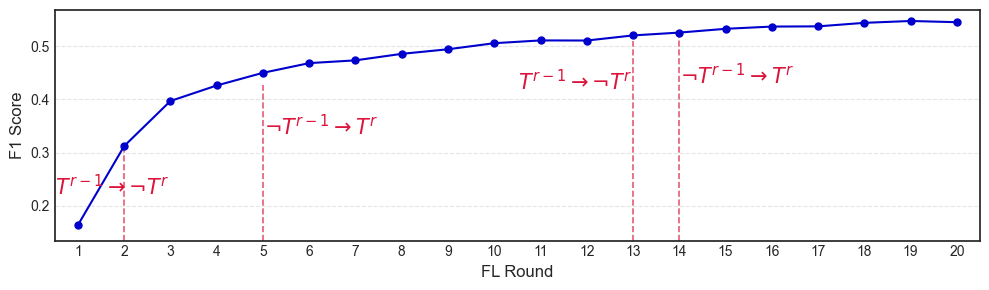

In [7]:
# --- 2. Plotting Code ---

def plot_val_f1_with_selector_switches(
        df: pd.DataFrame,
        exp_name: str,
        high_spec_clients: int,
        low_spec_clients: int,
        iid_data: bool
):
    """
    Plots 'Val F1' over FL rounds for a fixed client/data configuration.

    Draws a line for the experiment and adds partial vertical bars whenever the
    'Selector' column value changes, annotating the change with a LaTeX label.

    Args:
        df (pd.DataFrame): DataFrame with all experiment results.
        exp_name (str): The specific 'Exp Name' to filter for.
        high_spec_clients (int): The number of 'High-Spec Clients' for filtering.
        low_spec_clients (int): The number of 'Low-Spec Clients' for filtering.
        iid_data (bool): The value for 'IID Data' for filtering.
    """
    # --- Filter for the specific configuration ---
    plot_df = df[
        (df['Exp Name'] == exp_name) &
        (df['High-Spec Clients'] == high_spec_clients) &
        (df['Low-Spec Clients'] == low_spec_clients) &
        (df['IID Data'] == iid_data)
        ].copy()

    if plot_df.empty:
        print("Error: No data found for the specified configuration.")
        return

    # --- Create the plot ---
    plt.style.use('seaborn-v0_8-white')
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)

    # --- Process and plot the single experiment run ---
    # Sort by round to ensure correct line plotting and switch detection
    group = plot_df.sort_values('FL Round').reset_index()

    # Plot the main 'Val F1' line for this experiment
    ax.plot(
        group['FL Round'],
        group['Val F1'],
        marker='o',
        linestyle='-',
        label=f"{exp_name}",
        color='mediumblue',
        markersize=5,
        zorder=10  # Ensure the line is drawn on top of the vertical lines
    )

    # --- Detect, plot, and annotate vertical bars for selector switches ---
    # Use shift() to compare the current selector with the previous one
    group['prev_selector'] = group['Selector'].shift(1)

    # A switch occurs where the selector is different from the previous one
    # (ignoring the very first round, which has no predecessor)
    switch_points = group[
        (group['Selector'] != group['prev_selector']) & (group['FL Round'] > 0)
        ]

    # Set the bottom y-limit for the vertical lines
    plot_ymin = ax.get_ylim()[0]-0.01  # Or ax.get_ylim()[0] if you prefer it to be dynamic

    for _, row in switch_points.iterrows():
        fl_round = row['FL Round']
        f1_value = row['Val F1']
        prev_f1_value = row['Previous Val F1']
        prev_selector = row['prev_selector']
        current_selector = row['Selector']

        latex_label = ''
        # Heuristic to determine "ON" vs "OFF" states
        prev_is_on = 'True' in str(prev_selector)
        current_is_on = 'True' in str(current_selector)

        if prev_is_on and not current_is_on:
            latex_label = r"$\mathit{T}^{r-1}\to\neg\mathit{T}^{r}$"  # ON -> OFF
        elif not prev_is_on and current_is_on:
            latex_label = r"$\neg\mathit{T}^{r-1}\to\mathit{T}^{r}$"  # OFF -> ON

        if latex_label:
            # Draw the vertical line from the bottom of the plot up to the curve
            x_value = fl_round if fl_round != 3 else fl_round-1
            ax.vlines(
                x=x_value,
                ymin=plot_ymin,
                ymax=prev_f1_value,
                color='crimson',
                linestyle='--',
                alpha=0.7,
                linewidth=1.2
            )
            x_value = fl_round+1.25 if fl_round not in [13, 3] else fl_round-1.25
            # Add the LaTeX annotation just above the point on the curve
            ax.text(
                x=x_value,
                y=prev_f1_value-0.1,  # Position text slightly above the point
                s=latex_label,
                color='crimson',
                ha='center',  # Horizontal alignment
                va='bottom',  # Vertical alignment
                fontsize=15,
                zorder=11
            )

    # --- Formatting the plot ---
    title = (
        f"Validation F1 Score per FL Round for '{exp_name}'\n"
        f"Configuration: {high_spec_clients} High-Spec / {low_spec_clients} Low-Spec Clients, "
        f"Data: {'IID' if iid_data else 'Non-IID'}"
    )
    # ax.set_title(title, fontsize=16, weight='bold')
    ax.set_xlabel("FL Round", fontsize=12)
    ax.set_ylabel("F1 Score", fontsize=12)

    # --- Create a custom legend ---
    ax.plot([], [], color='crimson', linestyle='--', label='Selector State Change')
    # ax.legend(title="Legend")

    # Set axis limits and ticks
    ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
    ax.set_xlim(left=0.5, right=20.5)
    ax.set_ylim(bottom=plot_ymin)

    plt.tight_layout()
    plt.savefig("plots/policies/valf1_fixed_selector.pdf", dpi=300, bbox_inches='tight')
    plt.show()

# --- 3. Example Usage ---
# Call the function with the fixed configuration you want to analyze
plot_val_f1_with_selector_switches(
    df=exp_data_selector,
    exp_name='fixed-selector_9',
    high_spec_clients=5,
    low_spec_clients=5,
    iid_data=100
)

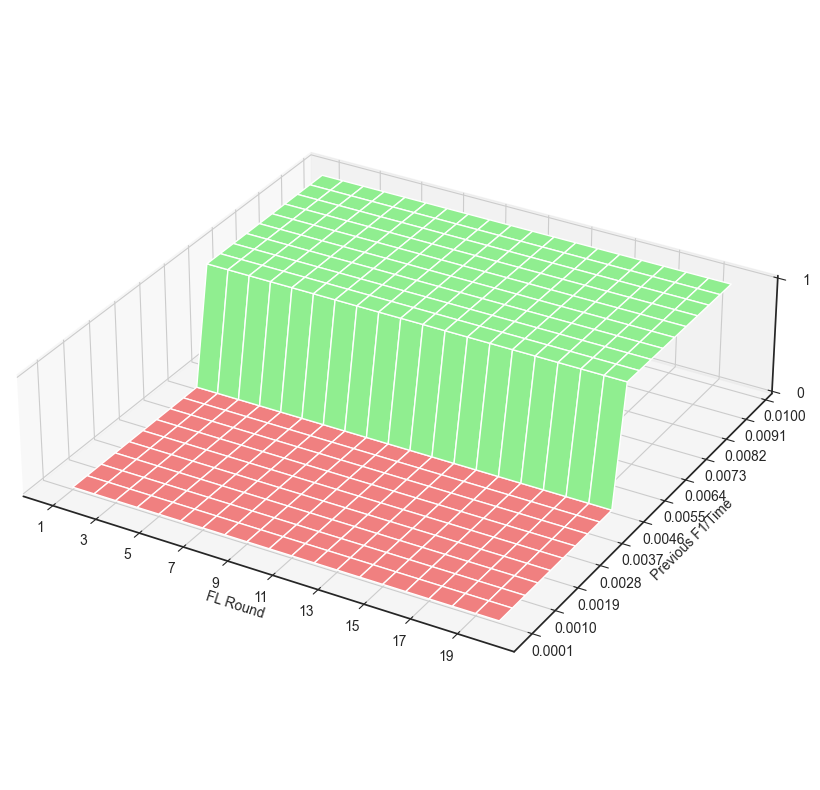

In [65]:
# --- Define the independent variables for the meshgrid ---
rounds = np.linspace(1, 20, 20)
# Adjust f1_over_time to better demonstrate the threshold
# Let's make it start lower and end higher, with smaller steps
f1_over_time = np.arange(0.0001, 0.01, 0.0005) # Smaller step size
X_mesh, Y_mesh = np.meshgrid(rounds, f1_over_time)

# --- Define your threshold ---
threshold_value = 0.005 # Changed threshold for better visibility of the split

# --- Prepare the Z array based on Y_mesh condition ---
Z = np.zeros_like(Y_mesh, dtype=int) # Z will contain 0s or 1s

# Set Z to 0 when Y_mesh (Previous F1/Time) is less than threshold_value, and 1 otherwise
Z[Y_mesh < threshold_value] = 0
Z[Y_mesh >= threshold_value] = 1

# --- Colormap and Plotting ---
color_inactive = 'lightcoral' # For Z=0 (Y_mesh < threshold_value)
color_active = 'lightgreen'   # For Z=1 (Y_mesh >= threshold_value)
colors = [color_inactive, color_active]
cmap = LinearSegmentedColormap.from_list("threshold_cmap", colors, N=2)

fig = plt.figure(figsize=(15, 8)) # Adjusted figsize for better viewing
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1, 1, 0.25)) # Adjust Z-axis compression as needed

ax.plot_surface(X_mesh, Y_mesh, Z, cmap=cmap)

ax.set_xlabel('FL Round')
ax.set_xticks(rounds[::2])
ax.set_ylabel('Previous F1/Time')
# Adjust yticks to match the new f1_over_time range and threshold
ax.set_yticks(np.arange(0.0001, 0.01, 0.0009)) # Adjust tick density
ax.set_zlabel(f'F1/Time Threshold State (1 >= {threshold_value}, 0 < {threshold_value})') # Add zlabel back for clarity
ax.set_zticks([0, 1])

plt.tight_layout()
plt.savefig("plots/policies/fixed_visualization.pdf", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

In [36]:
folders = ['vm/new/3high-3low/0iid',
           'vm/new/5high-5low/0iid',
           'vm/new/4high-2low/0iid',
           'vm/new/2high-4low/0iid']
selected_confs = ['always-hdh', 'fixed-hdh', 'random-hdh']
exp_data_hdh: pd.DataFrame = pd.DataFrame()


def shift_row(row, col_to_shift, shift_col, dataframe):
    return dataframe[col_to_shift].shift(row[shift_col])[row.name]


for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        exp_name = exp_path.split('/')[-1].split('_')[0]
        if exp_name not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['Client ID'] = df.apply(lambda x: int(x['Client ID'].split('Client ')[1].split('\n')[0]), axis=1)
            last_client = max([int(x) for x in df['Client ID'].unique()])
            high_spec_clients = int(folder.split('/')[2].split('high-')[0])
            low_spec_clients = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df['High-Spec Clients'] = high_spec_clients
            df['Low-Spec Clients'] = low_spec_clients
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])

            df['Previous JSD'] = df.shift(high_spec_clients + low_spec_clients)['JSD']

            df['HDH'] = df.apply(lambda x: x['HDH Time'] > 0.0, axis=1)
            df['shift_by'] = df.apply(lambda x: x['Client ID'] - last_client, axis=1)
            df['Filled F1/Time'] = df.apply(lambda row: shift_row(row, "F1/Time", "shift_by", df), axis=1)
            df['Filled F1'] = df.apply(lambda row: shift_row(row, "Val F1", "shift_by", df), axis=1)

            df['Previous Val F1'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1']
            df['Previous F1/Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1/Time']

            df['Final F1/Time'] = df["F1/Time"].iloc[-1]
            df['Final F1'] = df["Val F1"].iloc[-1]

            df = df[df['FL Round'] > 1]

            df = df[['Exp Name', 'Client ID', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'HDH', 'Total Time of FL Round', 'JSD', 'Previous JSD', 'F1/Time', 'Val F1',
                     'Previous Val F1', 'Previous F1/Time', 'Filled Total Time',
                     'Filled F1', 'Filled F1/Time', 'Final F1/Time', 'Final F1']]
            exp_data_hdh = pd.concat([exp_data_hdh, df])

# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
print(exp_data_hdh[(exp_data_hdh['High-Spec Clients'] == 3) & (exp_data_hdh['Exp Name'] == 'random-hdh_1')][
          ['Exp Name', 'Client ID', 'FL Round', 'Previous JSD', 'HDH', 'Filled F1']])

         Exp Name  Client ID  FL Round  Previous JSD    HDH  Filled F1
6    random-hdh_1          1         2          0.36  False     0.0375
7    random-hdh_1          2         2          0.29  False     0.0375
8    random-hdh_1          3         2          0.43  False     0.0375
9    random-hdh_1          4         2          0.26  False     0.0375
10   random-hdh_1          5         2          0.38  False     0.0375
..            ...        ...       ...           ...    ...        ...
115  random-hdh_1          2        20          0.05   True     0.4170
116  random-hdh_1          3        20          0.15  False     0.4170
117  random-hdh_1          4        20          0.07   True     0.4170
118  random-hdh_1          5        20          0.13   True     0.4170
119  random-hdh_1          6        20          0.10  False     0.4170

[114 rows x 6 columns]


In [8]:
folders = ['vm/same/3high-3low/0iid', 'vm/same/3high-3low/100iid',
           'vm/same/5high-5low/0iid', 'vm/same/5high-5low/100iid',
           'vm/same/4high-2low/0iid', 'vm/same/4high-2low/100iid',
           'vm/same/2high-4low/0iid', 'vm/same/2high-4low/100iid',
           'vm/same/2high-8low/0iid', 'vm/same/2high-8low/100iid',
           'vm/same/4high-8low/0iid', 'vm/same/4high-8low/100iid',
           'vm/same/8high-4low/0iid', 'vm/same/8high-4low/100iid']
selected_confs = ['always-compressor-2', 'no-compressor-2']
exp_data_compressor: pd.DataFrame = pd.DataFrame()


def shift_row(row, col_to_shift, shift_col, dataframe):
    return dataframe[col_to_shift].shift(row[shift_col])[row.name]


for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        exp_name = exp_path.split('/')[-1].split('_')[0]
        if exp_name not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['Client ID'] = df.apply(lambda x: int(x['Client ID'].split('Client ')[1].split('\n')[0]), axis=1)
            last_client = max([int(x) for x in df['Client ID'].unique()])
            high_spec_clients = int(folder.split('/')[2].split('high-')[0])
            low_spec_clients = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df['High-Spec Clients'] = high_spec_clients
            df['Low-Spec Clients'] = low_spec_clients
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])

            df['Compressor'] = exp_name.split('-')[0] == 'always'

            df['shift_by'] = df.apply(lambda x: x['Client ID'] - last_client, axis=1)
            df['Filled F1/Time'] = df.apply(lambda row: shift_row(row, "F1/Time", "shift_by", df), axis=1)
            df['Filled F1'] = df.apply(lambda row: shift_row(row, "Val F1", "shift_by", df), axis=1)
            df['Filled Total Time'] = df.apply(lambda row: shift_row(row, "Total Time of FL Round", "shift_by", df),
                                               axis=1)

            df['Previous Communication Time'] = df.shift(high_spec_clients + low_spec_clients)['Communication Time']
            df['Previous Val F1'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1']
            df['Previous Total Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled Total Time']
            df['Previous F1/Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1/Time']

            df['Final F1/Time'] = df["F1/Time"].iloc[-1]
            df['Final F1'] = df["Val F1"].iloc[-1]

            df = df[df['FL Round'] > 1]

            df = df[['Exp Name', 'Client ID', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'Total Time of FL Round', 'F1/Time', 'Previous Total Time', 'Compressor',
                     'Previous Communication Time', 'Filled Total Time',
                     'Communication Time', 'Filled F1/Time', 'Final F1/Time']]
            exp_data_compressor = pd.concat([exp_data_compressor, df])

# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
print(exp_data_compressor[(exp_data_compressor['Exp Name'] == 'always-compressor-2_1')][
          ['Exp Name', 'Client ID', 'FL Round', 'Compressor', 'Previous Communication Time', 'Total Time of FL Round']])

                  Exp Name  Client ID  FL Round  Compressor  \
10   always-compressor-2_1         23         2        True   
11   always-compressor-2_1         24         2        True   
12   always-compressor-2_1         25         2        True   
13   always-compressor-2_1         26         2        True   
14   always-compressor-2_1         27         2        True   
..                     ...        ...       ...         ...   
115  always-compressor-2_1         24        20        True   
116  always-compressor-2_1         25        20        True   
117  always-compressor-2_1         26        20        True   
118  always-compressor-2_1         27        20        True   
119  always-compressor-2_1         28        20        True   

     Previous Communication Time  Total Time of FL Round  
10                         44.51                     NaN  
11                         47.09                     NaN  
12                         45.55                     NaN  
13     

In [40]:
x = exp_data_selector[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Selector', 'FL Round', 'Previous F1/Time']]
y = exp_data_selector[['F1/Time']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8)

selector_tree_f1overtime = DecisionTreeRegressor(max_depth=8)
selector_tree_f1overtime.fit(x_train, y_train)

print(selector_tree_f1overtime.score(x_train, y_train))
print(selector_tree_f1overtime.score(x_test, y_test))

with open("../predictors/f1overtime_tree_selector_{}.pkl".format(len(x_train)), "wb") as f:
    dump(selector_tree_f1overtime, f, protocol=5)

0.9356245148775122
0.8933737279326143


In [99]:
x = exp_data_hdh[['FL Round', 'HDH', 'Previous JSD', 'Previous Val F1']]
y = exp_data_hdh[['Filled F1']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

hdh_tree_f1overtime = DecisionTreeRegressor(max_depth=10)
hdh_tree_f1overtime.fit(x_train, y_train)

print(hdh_tree_f1overtime.score(x_train, y_train))
print(hdh_tree_f1overtime.score(x_test, y_test))

with open("../predictors/f1overtime_tree_hdh_{}.pkl".format(len(x_train)), "wb") as f:
    dump(hdh_tree_f1overtime, f, protocol=5)

NameError: name 'exp_data_hdh' is not defined

In [9]:
x = exp_data_compressor[
    ['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Compressor', 'Previous Communication Time']]
y = exp_data_compressor[['Communication Time']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

compressor_tree_f1overtime = DecisionTreeRegressor(max_depth=10)
compressor_tree_f1overtime.fit(x_train, y_train)

print(compressor_tree_f1overtime.score(x_train, y_train))
print(compressor_tree_f1overtime.score(x_test, y_test))

with open("../predictors/f1overtime_tree_compressor_{}.pkl".format(len(x_train)), "wb") as f:
    dump(compressor_tree_f1overtime, f, protocol=5)

0.773123917613845
0.12477916468927441


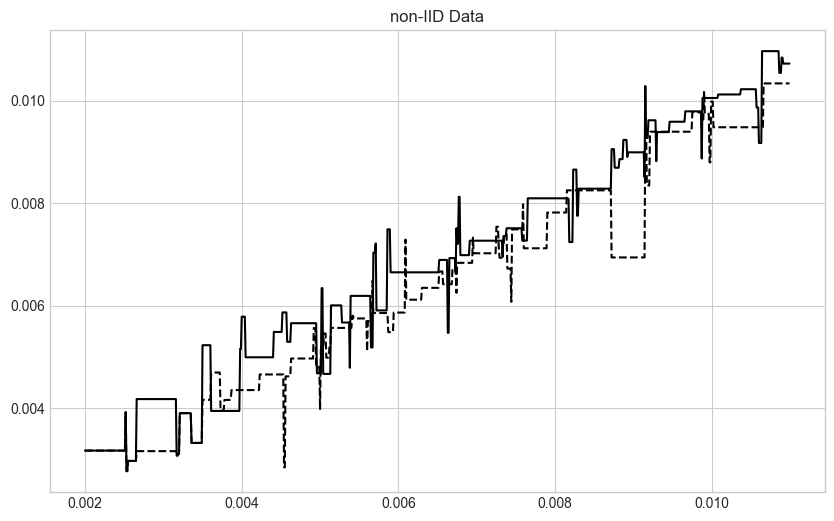

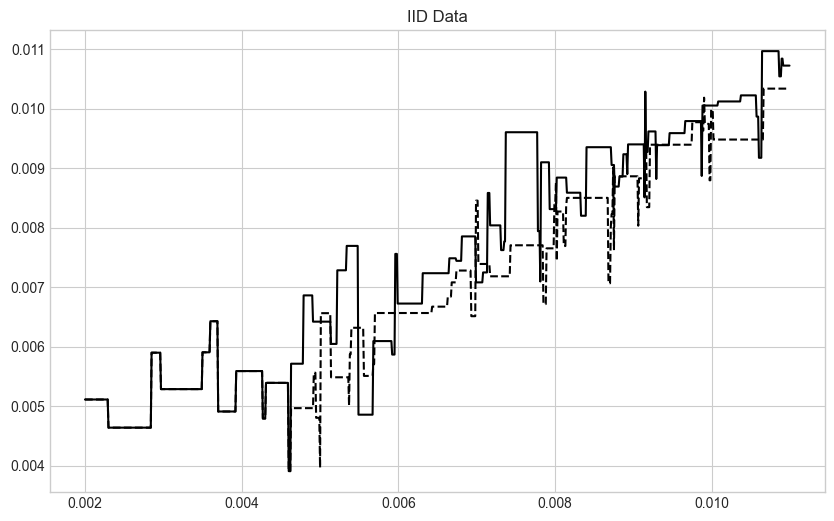

In [118]:
N_high = 5
N_low = 5

f1 = np.arange(0.002, 0.011, 0.00001)

plt.figure(figsize=(10, 6))

plt.plot(f1, [selector_tree_f1overtime.predict([[N_high, N_low, 0, True, v]])[0] for v in f1], color="black")
plt.plot(f1, [selector_tree_f1overtime.predict([[N_high, N_low, 0, False, v]])[0] for v in f1], '--', color="black")

plt.title('non-IID Data')

plt.show()

plt.figure(figsize=(10, 6))

plt.plot(f1, [selector_tree_f1overtime.predict([[N_high, N_low, 100, True, v]])[0] for v in f1], color="black")
plt.plot(f1, [selector_tree_f1overtime.predict([[N_high, N_low, 100, False, v]])[0] for v in f1], '--', color="black")

plt.title('IID Data')

plt.show()

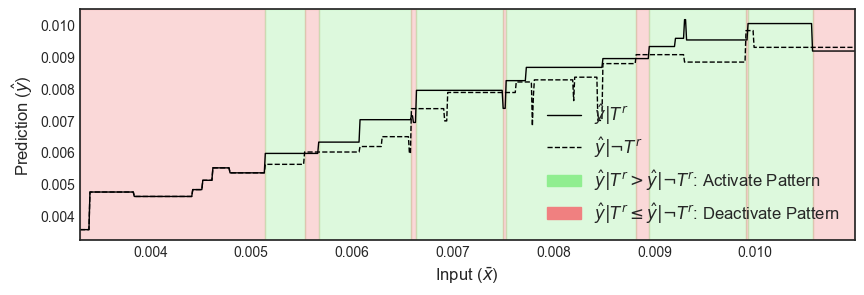

In [56]:
import matplotlib.patches as mpatches

def plot_decision_regions(selector_tree, N_high, N_low, iid_value, x_values):
    """
    Plots the decision tree's predictions for a pattern being active vs. inactive
    and colors the background based on which strategy is better.

    Args:
        selector_tree: The trained decision tree model with a .predict() method.
        N_high (int): Number of high-spec clients.
        N_low (int): Number of low-spec clients.
        iid_value (int): The IID data value (e.g., 100).
        x_values (np.ndarray): A range of values for the x-axis (e.g., previous F1 score).
    """
    # --- 1. Calculate the predictions for both lines ---
    # The 'solid' line represents the pattern being active (True)
    y_solid = [selector_tree.predict([[N_high, N_low, iid_value, True, 5, val]])[0] for val in x_values]

    # The 'dashed' line represents the pattern being inactive (False)
    y_dashed = [selector_tree.predict([[N_high, N_low, iid_value, False, 5, val]])[0] for val in x_values]

    # Convert to numpy arrays for easier comparison
    y_solid = np.array(y_solid)
    y_dashed = np.array(y_dashed)

    # --- 2. Create the plot ---
    fig, ax = plt.subplots(figsize=(10, 3))
    plt.style.use('seaborn-v0_8-white')

    # Plot the two prediction lines
    ax.plot(x_values, y_solid, color="black", label=r"$\hat{y}\vert\mathit{T}^{r}$", linewidth=1)
    ax.plot(x_values, y_dashed, '--', color="black", label=r"$\hat{y}\vert\neg\mathit{T}^{r}$", linewidth=1)

    # --- 3. Color the background regions ---
    # Determine where the solid line is better (>=) than the dashed line
    solid_is_better = y_solid > y_dashed

    # Define colors for the regions
    color_active = 'lightgreen'
    color_inactive = 'lightcoral'

    # Iterate through the x-values to find contiguous regions
    current_region_start = x_values[0]
    for i in range(1, len(x_values)):
        # A switch occurs if the "better" strategy changes
        if solid_is_better[i] != solid_is_better[i-1]:
            # End the previous region
            region_end = x_values[i]
            region_color = color_active if solid_is_better[i-1] else color_inactive
            ax.axvspan(current_region_start, region_end, color=region_color, alpha=0.3, zorder=0)

            # Start a new region
            current_region_start = region_end

    # Add the final region after the loop finishes
    final_region_color = color_active if solid_is_better[-1] else color_inactive
    ax.axvspan(current_region_start, x_values[-1], color=final_region_color, alpha=0.3, zorder=0)

    # --- 4. Formatting and Legend ---
    # ax.set_title("Decision Tree Policy Visualization", fontsize=16, weight='bold')
    ax.set_xlabel(r"Input ($\bar{x}$)", fontsize=12)
    ax.set_ylabel(r"Prediction ($\hat{y}$)", fontsize=12)

    # Create custom legend handles for the colored regions
    legend_patch_active = mpatches.Patch(color=color_active, alpha=1, label=r'$\hat{y}\vert\mathit{T}^{r}>\hat{y}\vert\neg\mathit{T}^{r}$: Activate Pattern')
    legend_patch_inactive = mpatches.Patch(color=color_inactive, alpha=1, label=r'$\hat{y}\vert\mathit{T}^{r}\leq\hat{y}\vert\neg\mathit{T}^{r}$: Deactivate Pattern')

    # Combine line legend with region legend
    handles, labels = ax.get_legend_handles_labels()
    handles.extend([legend_patch_active, legend_patch_inactive])
    ax.legend(handles=handles, facecolor='white', loc='best', fontsize=12)

    ax.set_xlim(x_values[0], x_values[-1])
    plt.savefig("plots/policies/decision_tree_policy_visualization.pdf", dpi=300, bbox_inches='tight')
    plt.show()

# Call the plotting function with the mock model and parameters
f1_values = np.arange(0.0033, 0.011, 0.00001)

plot_decision_regions(
    selector_tree=selector_tree_f1overtime,
    N_high=5,
    N_low=5,
    iid_value=100,
    x_values=f1_values
)

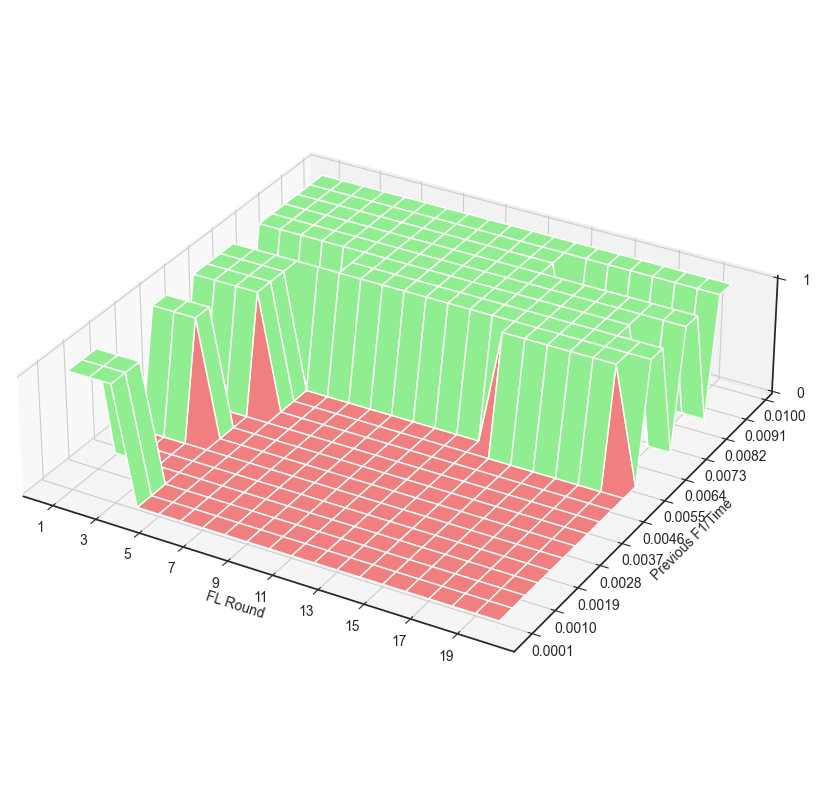

In [59]:
# --- Define the independent variables for the meshgrid ---
# Use the same ranges as your previous plot, adjust if needed
rounds = np.linspace(1, 20, 20)
f1_over_time = np.arange(0.0001, 0.01, 0.0005)
X_mesh, Y_mesh = np.meshgrid(rounds, f1_over_time) # Renamed to avoid confusion with X in objective

# --- Define your selector_tree prediction function ---
# This function will take the policy_on/off state and other features
# and return the prediction from selector_tree.
# I'm assuming the structure of your input X for selector_tree.
# Adjust the hardcoded values (5, 5, 100) and feature order to match
# what your selector_tree expects for the scaled input.
def get_selector_tree_prediction(selector_state, curr_round, prev_f1_overtime):
    # Construct the input array for selector_tree.
    # IMPORTANT: Ensure the feature order matches the training data of selector_tree.
    # This is a placeholder; you might need to adjust the fixed values (e.g., 5, 5, 100)
    # and the position of 'selector_state', 'curr_round', 'prev_f1_overtime'
    input_features = np.array([[5, 5, 100, selector_state, curr_round, prev_f1_overtime]])
    # input_scaled = scaler.transform(input_features)
    prediction = selector_tree_f1overtime.predict(input_features)[0]
    return prediction

# --- Prepare the Z array for the surface plot ---
Z = np.zeros_like(X_mesh, dtype=int) # Z will contain 0s or 1s

for i in range(X_mesh.shape[0]):
    for j in range(X_mesh.shape[1]):
        curr_round = X_mesh[i, j]
        prev_f1_overtime = Y_mesh[i, j]

        # Get prediction when selector is ON (e.g., selector_state = 1)
        pred_selector_on = get_selector_tree_prediction(1, curr_round, prev_f1_overtime)

        # Get prediction when selector is OFF (e.g., selector_state = 0)
        pred_selector_off = get_selector_tree_prediction(0, curr_round, prev_f1_overtime)

        # Set Z to 1 if 'selector on' is better, else 0
        if pred_selector_on > pred_selector_off:
            Z[i, j] = 1 # Selector ON is preferred
        else:
            Z[i, j] = 0 # Selector OFF is preferred (or no significant difference)

# --- Colormap and Plotting ---
color_active = 'lightgreen' # For Z=1 (selector_on > selector_off)
color_inactive = 'lightcoral' # For Z=0 (selector_on <= selector_off)
colors = [color_inactive, color_active]
cmap = LinearSegmentedColormap.from_list("selector_cmap", colors, N=2)

fig = plt.figure(figsize=(15, 8)) # Adjusted figsize for better viewing
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1, 1, 0.25)) # Adjust Z-axis compression as needed

ax.plot_surface(X_mesh, Y_mesh, Z, cmap=cmap)

ax.set_xlabel('FL Round')
ax.set_xticks(rounds[::2]) # Show fewer ticks if `rounds` is too dense
ax.set_ylabel('Previous F1/Time')
ax.set_yticks(np.arange(0.0001, 0.01, 0.0009))
ax.set_zlabel('Selector Toggle State (1=ON, 0=OFF)')
ax.set_zticks([0, 1]) # Ensure only 0 and 1 are shown on Z-axis

plt.tight_layout()
plt.savefig("plots/policies/predictor_visualization.pdf", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

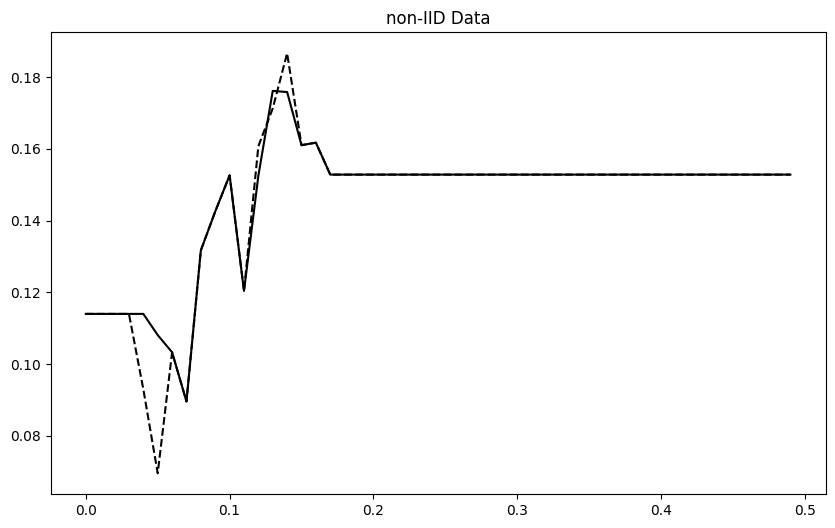

In [20]:
N_high = 2
N_low = 8

f1 = np.arange(0, 0.5, 0.01)

plt.figure(figsize=(10, 6))

plt.plot(f1, [hdh_tree_f1overtime.predict([[4, True, 0.05, v]])[0] for v in f1], color="black")
plt.plot(f1, [hdh_tree_f1overtime.predict([[4, False, 0.05, v]])[0] for v in f1], '--', color="black")

plt.title('non-IID Data')

plt.show()

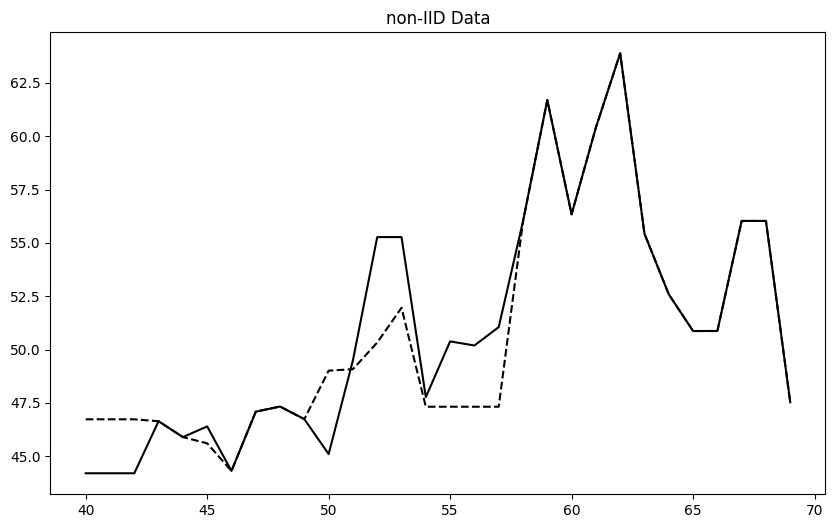

In [13]:
x = np.arange(40, 70, 1.0)

plt.figure(figsize=(10, 6))

plt.plot(x, [compressor_tree_f1overtime.predict([[2, 4, 100, True, v]])[0] for v in x], color="black")
plt.plot(x, [compressor_tree_f1overtime.predict([[2, 4, 100, False, v]])[0] for v in x], '--', color="black")

plt.title('non-IID Data')

plt.show()

In [21]:
# Features and target
x = exp_data_selector[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Selector', 'FL Round', 'Previous F1/Time']]
y = exp_data_selector[['F1/Time']]

# Standardize input (important for GPR)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

# Define GPR with RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-4, normalize_y=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.7, random_state=42)

# Fit model
# WARNING!! Takes approx. 1 min to complete
gpr.fit(X_train, y_train)

joblib.dump(gpr, '../predictors/bo_model.pkl')
joblib.dump(scaler, '../predictors/bo_scaler.pkl')

# Predict on test set
y_pred, sigma = gpr.predict(X_test, return_std=True)

# Output example
for xi, pred, std in zip(X_test, y_pred, sigma):
    print(f"Input: {scaler.inverse_transform([xi])[0]} → Predicted accuracy: {pred:.3f} ± {std:.3f}")

Input: [5.00000000e+00 5.00000000e+00 1.00000000e+02 0.00000000e+00
 1.30000000e+01 9.26615757e-03] → Predicted accuracy: 0.010 ± 0.008
Input: [5.00000000e+00 5.00000000e+00 1.00000000e+02 0.00000000e+00
 7.00000000e+00 7.89917412e-03] → Predicted accuracy: 0.008 ± 0.003
Input: [5.00000000e+00 5.00000000e+00 1.00000000e+02 0.00000000e+00
 1.20000000e+01 9.80651909e-03] → Predicted accuracy: 0.009 ± 0.034
Input: [2.00000000e+00 4.00000000e+00 0.00000000e+00 0.00000000e+00
 1.80000000e+01 6.40034217e-03] → Predicted accuracy: 0.005 ± 0.019
Input: [8.00000000e+00 4.00000000e+00 0.00000000e+00 0.00000000e+00
 1.30000000e+01 6.90531591e-03] → Predicted accuracy: 0.002 ± 0.045
Input: [5.00000000e+00 5.00000000e+00 1.00000000e+02 0.00000000e+00
 1.30000000e+01 8.86519824e-03] → Predicted accuracy: 0.010 ± 0.046
Input: [4.00000000e+00 2.00000000e+00 1.00000000e+02 0.00000000e+00
 3.00000000e+00 5.75904449e-03] → Predicted accuracy: 0.006 ± 0.004
Input: [3.00000000e+00 3.00000000e+00 1.00000000

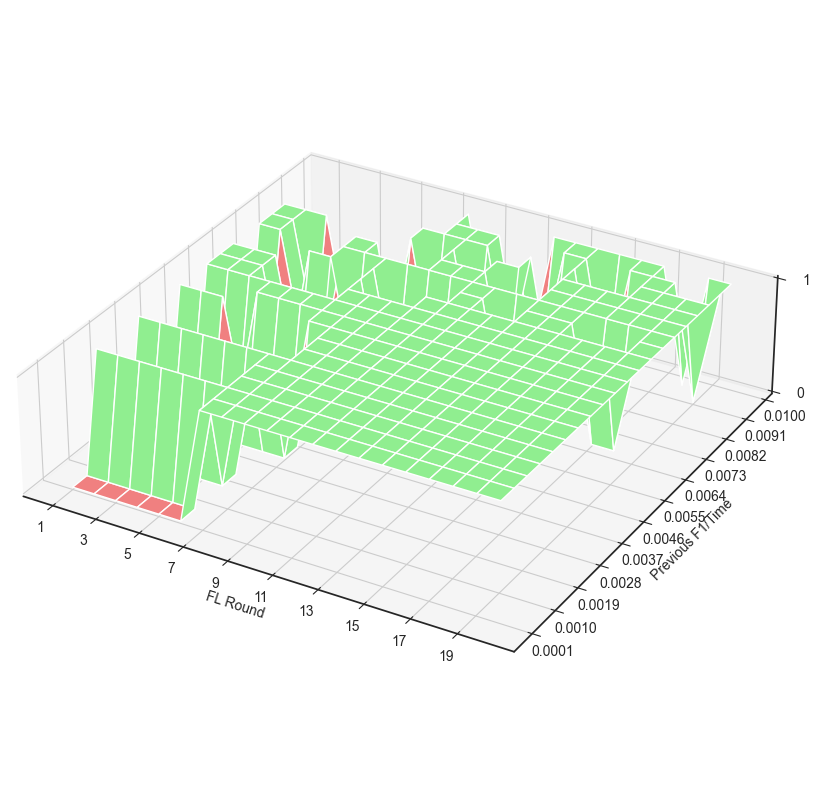

In [60]:
gpr = joblib.load('../predictors/bo_model.pkl')

rounds = np.linspace(1, 20, 20)
f1_over_time = np.arange(0.0001, 0.01, 0.0005)
X, Y = np.meshgrid(rounds, f1_over_time)


def objective(policy_on, curr_round, prev_f1_overtime):  # binary: 0 or 1
    X = [[5, 5, 100, policy_on[0], curr_round, prev_f1_overtime]]
    X_scaled = scaler.transform(X)
    y_pred = -gpr.predict(X_scaled)[0]  # maximize → minimize negative
    return y_pred


Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        def wrapped_objective(policy_on):
            curr_round = X[i, j]
            prev_f1_overtime = Y[i, j]

            return objective(policy_on, curr_round, prev_f1_overtime)


        res = gp_minimize(wrapped_objective,  # objective fn
                          [(0, 1)],  # policy_on ∈ {0,1}
                          acq_func="EI",  # acquisition function
                          n_calls=10, random_state=42)

        Z[i, j] = res.x[0]

color_active = 'lightgreen'
color_inactive = 'lightcoral'
colors = [color_inactive, color_active]
cmap = LinearSegmentedColormap.from_list("mycmap", colors, N=2) # N=2 for 2 discrete values

# Plot the surface
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1, 1, 0.25))
ax.plot_surface(X, Y, Z, cmap=cmap)

ax.set_xlabel('FL Round')
ax.set_xticks(rounds[::2])
ax.set_ylabel('Previous F1/Time')
ax.set_yticks(np.arange(0.0001, 0.01, 0.0009))
ax.set_zlabel('Pattern Toggle State')
ax.set_zticks([0, 1])
plt.tight_layout()
plt.savefig("plots/policies/bo_visualization.pdf", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()


In [18]:
# Features and target
x = exp_data_hdh[['FL Round', 'HDH', 'Previous JSD', 'Previous Val F1']]
y = exp_data_hdh[['Filled F1']]

# Standardize input (important for GPR)
scaler_hdh = StandardScaler()
X_scaled = scaler_hdh.fit_transform(x)

# Define GPR with RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
gpr_hdh = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-4, normalize_y=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.7, random_state=42)

# Fit model
# WARNING!! Takes approx. 1 min to complete
gpr_hdh.fit(X_train, y_train)

joblib.dump(gpr_hdh, '../predictors/bo_model_hdh.pkl')
joblib.dump(scaler_hdh, '../predictors/bo_scaler_hdh.pkl')

# Predict on test set
y_pred, sigma = gpr_hdh.predict(X_test, return_std=True)

# Output example
for xi, pred, std in zip(X_test, y_pred, sigma):
    print(f"Input: {scaler_hdh.inverse_transform([xi])[0]} → Predicted accuracy: {pred:.3f} ± {std:.3f}")

Input: [15.      1.      0.18    0.3581] → Predicted accuracy: 0.336 ± 2.818
Input: [2.00000000e+00 2.77555756e-17 2.80000000e-01 3.48000000e-02] → Predicted accuracy: 0.137 ± 0.174
Input: [14.      1.      0.13    0.3383] → Predicted accuracy: 0.402 ± 1.028
Input: [9.00000000e+00 2.77555756e-17 7.00000000e-02 2.78900000e-01] → Predicted accuracy: 0.348 ± 0.001
Input: [8.00000000e+00 2.77555756e-17 1.70000000e-01 2.33400000e-01] → Predicted accuracy: 0.268 ± 0.136
Input: [7.     1.     0.28   0.2225] → Predicted accuracy: 0.245 ± 0.449
Input: [1.00000000e+01 2.77555756e-17 3.40000000e-01 2.69600000e-01] → Predicted accuracy: 0.293 ± 3.149
Input: [1.30000000e+01 2.77555756e-17 1.00000000e-01 3.11600000e-01] → Predicted accuracy: -0.101 ± 2.167
Input: [1.50000000e+01 2.77555756e-17 1.40000000e-01 3.37000000e-01] → Predicted accuracy: 0.355 ± 0.347
Input: [1.90000000e+01 2.77555756e-17 3.40000000e-01 3.59200000e-01] → Predicted accuracy: 0.343 ± 3.042
Input: [1.60000000e+01 2.77555756e-17

In [8]:
gpr_hdh = joblib.load('../predictors/bo_model_hdh.pkl')

rounds = np.linspace(1, 20, 20)
f1_over_time = np.arange(0, 0.5, 0.01)
X, Y = np.meshgrid(rounds, f1_over_time)

last_jsd = 0.1


def objective(policy_on, curr_round, last_jsd, prev_f1):  # binary: 0 or 1
    X = [[curr_round, policy_on[0], last_jsd, prev_f1]]
    X_scaled = scaler_hdh.transform(X)
    y_pred = -gpr_hdh.predict(X_scaled)[0]  # maximize → minimize negative
    return y_pred


Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        def wrapped_objective(policy_on):
            curr_round = X[i, j]
            prev_f1_overtime = Y[i, j]

            return objective(policy_on, curr_round, last_jsd, prev_f1_overtime)


        res = gp_minimize(wrapped_objective,  # objective fn
                          [(0, 1)],  # policy_on ∈ {0,1}
                          acq_func="EI",  # acquisition function
                          n_calls=10, random_state=42)

        Z[i, j] = res.x[0]

# Plot the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('FL Round')
ax.set_ylabel('Previous F1/Time')
ax.set_zlabel('HDH on')
plt.title("Performance Surface")
plt.show()


NameError: name 'scaler_hdh' is not defined

In [16]:
# Features and target
x = exp_data_compressor[
    ['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Compressor', 'Previous Communication Time']]
y = exp_data_compressor[['Communication Time']]

# Standardize input (important for GPR)
scaler_compressor = StandardScaler()
X_scaled = scaler_compressor.fit_transform(x)

# Define GPR with RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
gpr_compressor = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-4, normalize_y=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.7, random_state=42)

# Fit model
# WARNING!! Takes approx. 1 min to complete
gpr_compressor.fit(X_train, y_train)

joblib.dump(gpr_compressor, '../predictors/bo_model_compressor.pkl')
joblib.dump(scaler_compressor, '../predictors/bo_scaler_compressor.pkl')

# Predict on test set
y_pred, sigma = gpr_compressor.predict(X_test, return_std=True)

# Output example
for xi, pred, std in zip(X_test, y_pred, sigma):
    print(f"Input: {scaler_compressor.inverse_transform([xi])[0]} → Predicted accuracy: {pred:.3f} ± {std:.3f}")

Input: [ 2.    4.    0.    0.   45.93] → Predicted accuracy: 45.189 ± 0.026
Input: [  5.    5.  100.    1.   47.6] → Predicted accuracy: 48.361 ± 0.019
Input: [ 2.    4.    0.    1.   56.14] → Predicted accuracy: 49.081 ± 7.883
Input: [  5.     5.   100.     0.    49.34] → Predicted accuracy: 48.324 ± 0.020
Input: [  2.     4.   100.     0.    47.21] → Predicted accuracy: 37.885 ± 0.157
Input: [  5.     5.   100.     0.    51.37] → Predicted accuracy: 52.022 ± 92.796
Input: [  5.     5.   100.     1.    48.65] → Predicted accuracy: 48.523 ± 0.015
Input: [ 2.    4.    0.    0.   46.27] → Predicted accuracy: 46.506 ± 0.053
Input: [  5.     5.   100.     1.    48.83] → Predicted accuracy: 49.605 ± 0.020
Input: [  2.     4.   100.     0.    44.65] → Predicted accuracy: 46.599 ± 0.029
Input: [  4.     2.   100.     1.    46.13] → Predicted accuracy: 46.694 ± 0.019
Input: [  4.     2.   100.     0.    43.11] → Predicted accuracy: 42.900 ± 0.029
Input: [  5.     5.   100.     1.    48.88] → P

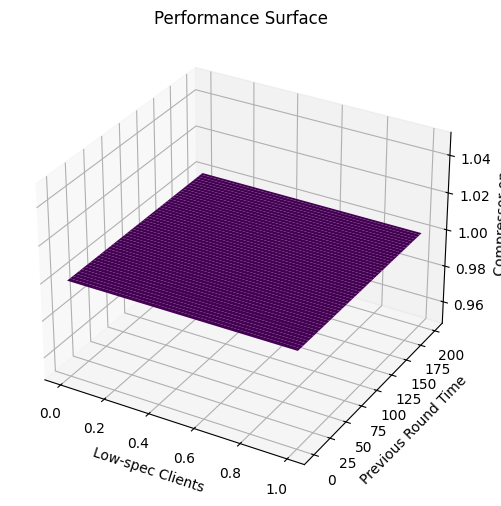

In [17]:
# ['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Compressor', 'Previous Total Time']

gpr_compressor = joblib.load('../predictors/bo_model_compressor.pkl')

iid_data = np.arange(0, 2, 1)
round_time = np.arange(0, 200, 1)
X, Y = np.meshgrid(iid_data, round_time)


def objective(policy_on, high_spec, low_spec, iid, prev_time):  # binary: 0 or 1
    X = [[high_spec, low_spec, iid, policy_on[0], prev_time]]
    X_scaled = scaler_compressor.transform(X)
    y_pred = gpr_compressor.predict(X_scaled)[0]  # maximize → minimize negative
    return y_pred


Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        def wrapped_objective(policy_on):
            iid_data = X[i, j]
            prev_round_time = Y[i, j]

            return objective(policy_on, 5, 5, iid_data, prev_round_time)


        res = gp_minimize(wrapped_objective,  # objective fn
                          [(0, 1)],  # policy_on ∈ {0,1}
                          acq_func="EI",  # acquisition function
                          n_calls=10, random_state=42)

        Z[i, j] = res.x[0]

# Plot the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('Low-spec Clients')
ax.set_ylabel('Previous Round Time')
ax.set_zlabel('Compressor on')
plt.title("Performance Surface")
plt.show()
